# Multi-Layer Perceptron (MLP) on Sophon Embeddings

This notebook trains a simple fully-connected neural network on Sophon's learned jet embeddings to classify 10 JetClass categories. We use the 128-dimensional embeddings extracted from the Sophon model's penultimate layer as input features.

## Workflow
1. **Load and prepare data** - Load Sophon inference results, extract embeddings, split into train/val/test
2. **Define MLP architecture** - Simple 4-layer fully connected network
3. **Setup training** - Define loss, optimizer, and training loop
4. **Train the model** - Run training with validation monitoring
5. **Evaluate on test set** - Compute accuracy and per-class AUC scores
6. **Visualize results** - Plot per-class ROC curves

## JetClass Categories

The dataset contains 10 jet classes representing different particle physics processes:

| Class ID | Jet Type | Physics Process |
|----------|----------|-----------------|
| 0 | **ZJetsToNuNu** | QCD background (Z→νν) |
| 1 | **HToBB** | Higgs → bottom quarks |
| 2 | **HToCC** | Higgs → charm quarks |
| 3 | **HToGG** | Higgs → gluons |
| 4 | **HToWW2Q1L** | Higgs → WW (2 quarks, 1 lepton) |
| 5 | **HToWW4Q** | Higgs → WW (4 quarks) |
| 6 | **TTBar** | Top-antitop (hadronic) |
| 7 | **TTBarLep** | Top-antitop (leptonic) |
| 8 | **WToQQ** | W boson → quarks |
| 9 | **ZToQQ** | Z boson → quarks |

**Note**: Class 0 (QCD/ZJetsToNuNu) is typically the "background" that physicists want to reject, while the Higgs decay modes (classes 1-5) are often the "signal" of interest.

## Step 1: Load and Prepare Data

Load Sophon inference CSV files from the `inference/` directory. Each file contains:
- **128-dimensional embeddings** (`emb_0` to `emb_127`) from Sophon's penultimate layer
- **Truth labels** indicating the actual jet type (class 0-9)

The embeddings serve as features for our MLP classifier. We'll split the combined dataset into 70% training, 15% validation, and 15% test sets, maintaining class balance with stratified splitting.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

df_qcd = pd.read_csv("ZJetsToNuNu_inference_with_embedding.csv")
df_hbb = pd.read_csv("HToBB_inference_with_embedding.csv")
df_hcc = pd.read_csv("HToCC_inference_with_embedding.csv")
df_hgg = pd.read_csv("HToGG_inference_with_embedding.csv")
df_hww2q1l = pd.read_csv("HToWW2_inference_with_embedding.csv")
df_hww4q = pd.read_csv("HToWW4Q_inference_with_embedding.csv")
df_ttbar = pd.read_csv("TTBar_inference_with_embedding.csv")
df_ttbarlep = pd.read_csv("TTBarLep_inference_with_embedding.csv")
df_wtoqq = pd.read_csv("WToQQ_inference_with_embedding.csv")
df_ztoqq = pd.read_csv("ZToQQ_inference_with_embedding.csv")
df_all = pd.concat([df_qcd, df_hbb, df_hcc, df_hgg, df_hww2q1l, df_hww4q, df_ttbar, df_ttbarlep, df_wtoqq, df_ztoqq], ignore_index=True)

# combine datasets
df_all_classes = pd.concat([df_qcd, df_hbb, df_hcc, df_hgg, df_hww2q1l, df_hww4q, df_ttbar, df_ttbarlep, df_wtoqq, df_ztoqq], ignore_index=True)

# embeddings and labels
X = df_all_classes[[f"emb_{j}" for j in range(128)]].to_numpy(dtype=np.float32)
y = df_all_classes["truth_label"].to_numpy(dtype=np.int64)

print("Embeddings:", X.shape, "Labels:", y.shape)

# train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# to tensors
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds   = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=512)
test_loader  = DataLoader(test_ds, batch_size=512)
# use test_loader to get the AUCs (only use this to get the AUC plot)

/var/folders/5h/bbvlvy693ysc_l8vfb_2_w4w0000gn/T/ipykernel_97551/3322845358.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_qcd, df_hbb, df_hcc, df_hgg, df_hww2q1l, df_hww4q, df_ttbar, df_ttbarlep, df_wtoqq, df_ztoqq], ignore_index=True)
/var/folders/5h/bbvlvy693ysc_l8vfb_2_w4w0000gn/T/ipykernel_97551/3322845358.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_classes = pd.concat([df_qcd, df_hbb, df_hcc, df_hgg, df_hww2q1l, df_hww4q, df_ttbar, df_ttbarlep, 

Before filtering: 899985 samples
After filtering: 899985 samples
Embeddings: (899985, 128) Labels: (899985,)


## Step 2: Define MLP Architecture

Define a simple multi-layer perceptron with the following structure:
- **Input**: 128-dimensional embeddings
- **Hidden layers**: 256 → 128 → 64 units with ReLU activation
- **Output**: 10 class logits (softmax applied in loss function)

This architecture gradually reduces dimensionality while learning non-linear transformations of the embedding space.

In [4]:
# MLP model
class MLP(nn.Module):
    def __init__(self, input_dim=128, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.net(x)
    # 128 → 256 → 128 → 64 → 10

## Step 3: Setup Training Infrastructure

Configure the training setup:
- **Device**: Use GPU (CUDA) if available, otherwise CPU
- **Loss function**: CrossEntropyLoss (combines softmax + negative log likelihood)
- **Optimizer**: Adam with learning rate 1e-3
- **Training function**: Implements forward pass, backprop, and validation monitoring per epoch

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        # print the loss and accuracy for each epoch
        # Training

        model.train()
        train_loss, train_correct = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            train_correct += (outputs.argmax(1) == yb).sum().item()
        train_acc = train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                val_correct += (outputs.argmax(1) == yb).sum().item()
        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Loss {train_loss:.4f} Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

## Step 4: Train the Model

Execute training for 1 epoch with the training loop defined above. This computes loss on training batches and validates on the held-out validation set.

In [6]:
train_model(model, train_loader, val_loader, epochs=1)

Epoch 1: Loss 14682.4543 Train Acc 0.9980, Val Acc 1.0000


## Step 5: Evaluate Test Accuracy

Compute overall classification accuracy on the held-out test set. Expected result: near-perfect accuracy since Sophon's embeddings are highly discriminative for the classes it was trained on.

In [7]:
# final test
model.eval()
test_correct = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        test_correct += (preds == yb).sum().item()

print(f"Test Accuracy: {test_correct / len(test_loader.dataset):.4f}")
# add an auc metric
# add loss too

Test Accuracy: 1.0000


## Step 6: Compute Per-Class AUC Scores

Generate softmax probabilities on the test set and compute one-vs-rest ROC-AUC for each of the 10 jet classes. This provides per-class discrimination performance: how well the model separates each class from all others.

In [8]:
# pretty much perfect accuracy....

In [9]:
# # AUC metric
# import pandas as pd
# import numpy as np
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # ===== Load Jason's ParT results =====
# part_df = pd.read_csv("/Users/jovannareyes/Desktop/sophon_project/sophon/csvfiles/full_inference_output.csv")  # Jason's file
# part_truth = part_df["truth"].values
# part_probs = part_df[[f"P_{i}" for i in range(10)]].values

# mask_part = np.isin(part_truth, [0, 1])
# y_true_part = (part_truth[mask_part] == 1).astype(int)
# p_hbb_part = part_probs[mask_part, 1]
# p_qcd_part = part_probs[mask_part, 0]
# disc_part = p_hbb_part / (p_hbb_part + p_qcd_part)

# fpr_part, tpr_part, _ = roc_curve(y_true_part, disc_part)
# roc_auc_part = auc(fpr_part, tpr_part)

# # sklearn.metrics.roc_auc_score(y_true_part, disc_part, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)

# # Find TPR at FPR ~ 1e-3 for ParT
# target_fpr = 1e-3
# idx_part = np.argmin(np.abs(fpr_part - target_fpr))
# print(f"ParT: Closest FPR to {target_fpr} is {fpr_part[idx_part]:.6f}, TPR = {tpr_part[idx_part]:.6f}")

# # ===== Load your Sophon results =====
# hbb_df = pd.read_csv("HToBB_inference_with_embedding.csv")
# qcd_df = pd.read_csv("ZToNuNu_inference_with_embedding_clean.csv")

# hbb_probs = hbb_df[[f"prob_{i}" for i in range(10)]].to_numpy()
# qcd_probs = qcd_df[[f"prob_{i}" for i in range(10)]].to_numpy()

# all_probs = np.vstack([hbb_probs, qcd_probs])
# all_labels = np.array([1] * len(hbb_probs) + [0] * len(qcd_probs))

# mask_sophon = np.isin(all_labels, [0, 1])
# y_true_sophon = (all_labels[mask_sophon] == 1).astype(int)
# p_hbb_sophon = all_probs[mask_sophon, 1]
# p_qcd_sophon = all_probs[mask_sophon, 0]
# disc_sophon = p_hbb_sophon / (p_hbb_sophon + p_qcd_sophon)

# fpr_sophon, tpr_sophon, _ = roc_curve(y_true_sophon, disc_sophon)
# roc_auc_sophon = auc(fpr_sophon, tpr_sophon)

# # Find TPR at FPR ~ 1e-3 for Sophon
# idx_sophon = np.argmin(np.abs(fpr_sophon - target_fpr))
# print(f"Sophon: Closest FPR to {target_fpr} is {fpr_sophon[idx_sophon]:.6f}, TPR = {tpr_sophon[idx_sophon]:.6f}")

# # ===== Plot both =====
# eps = 1e-5
# plt.figure()
# plt.plot(tpr_part, np.clip(fpr_part, eps, 1.0), label=f"ParT (AUC={roc_auc_part:.3f})")
# plt.plot(tpr_sophon, np.clip(fpr_sophon, eps, 1.0), label=f"Sophon (AUC={roc_auc_sophon:.3f})")
# plt.xlim(0, 1)
# plt.ylim(eps, 1.0)
# plt.xscale("linear")
# plt.yscale("log")
# plt.xlabel("True Positive Rate")
# plt.ylabel("False Positive Rate (log scale)")
# plt.title("ROC: H→bb vs QCD")
# plt.legend(loc="lower right")
# plt.grid(True, which="both", ls=":")
# plt.savefig("plot_example.svg", format="svg", transparent=True, dpi=300)
# plt.show()

In [10]:
# class_files = {
#     0: "HToBB_inference_with_embedding.csv",
#     1: "HToCC_inference_with_embedding.csv",
#     2: "HToGG_inference_with_embedding.csv",
#     3: "HToWW2Q1L_inference_with_embedding.csv",
#     4: "HToWW4Q_inference_with_embedding.csv",
#     5: "TTBar_inference_with_embedding.csv",
#     6: "TTBarLep_inference_with_embedding.csv",
#     7: "WToQQ_inference_with_embedding.csv",
#     8: "ZToQQ_inference_with_embedding.csv",
#     9: "ZToNuNu_inference_with_embedding_clean.csv"  # QCD
# }

In [11]:
# dfs = []
# for class_id, fname in class_files.items():
#     df = pd.read_csv(fname)
#     df["truth_label"] = class_id  
#     dfs.append(df)

# df_all = pd.concat(dfs, ignore_index=True)
# print("Combined shape:", df_all.shape)
# print(df_all["truth_label"].value_counts())

In [12]:
# X = df_all[[f"emb_{j}" for j in range(128)]].to_numpy(dtype=np.float32)
# y = df_all["truth_label"].to_numpy(dtype=np.int64)

In [13]:
# use the X and Y from the test set to get the AUCs

In [14]:
from sklearn.metrics import roc_curve, auc

model.eval()
with torch.no_grad():
    logits = model(torch.from_numpy(X_test).float().to(device))
    probs_test = torch.softmax(logits, dim=1).cpu().numpy()

auc_per_class = {}
for i in range(10):
    if np.sum(y_test == i) == 0:
        print(f"Class {i}: no samples in test set, skipping")
        continue
    y_true_bin = (y_test == i).astype(int)
    y_score = probs_test[:, i]   # use test probs
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    auc_per_class[i] = auc(fpr, tpr)
    print(f"Class {i}: AUC = {auc_per_class[i]:.4f}")

# def train_model(model, train_loader, val_loader, epochs=10):
#     for epoch in range(epochs):
#         # print the loss and accuracy for each epoch
#         # Training

#         model.train()
#         train_loss, train_correct = 0, 0
#         for xb, yb in train_loader:
#             xb, yb = xb.to(device), yb.to(device)
#             optimizer.zero_grad()
#             outputs = model(xb)
#             loss = criterion(outputs, yb)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * xb.size(0)
#             train_correct += (outputs.argmax(1) == yb).sum().item()
#         train_acc = train_correct / len(train_loader.dataset)

#         # Validation
#         model.eval()
#         val_loss, val_correct = 0, 0
#         with torch.no_grad():
#             for xb, yb in val_loader:
#                 xb, yb = xb.to(device), yb.to(device)
#                 outputs = model(xb)
#                 loss = criterion(outputs, yb)
#                 val_loss += loss.item() * xb.size(0)
#                 val_correct += (outputs.argmax(1) == yb).sum().item()
#         val_acc = val_correct / len(val_loader.dataset)

#         print(f"Epoch {epoch+1}: Loss {train_loss:.4f} Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")


Class 0: AUC = 1.0000
Class 1: AUC = 1.0000
Class 2: AUC = 1.0000
Class 3: AUC = 1.0000
Class 4: AUC = 1.0000
Class 5: no samples in test set, skipping
Class 6: AUC = 1.0000
Class 7: AUC = 1.0000
Class 8: AUC = 1.0000
Class 9: AUC = 1.0000


## Step 7: Visualize Per-Class ROC Curves

Plot ROC curves for each of the 10 jet classes using logarithmic scales. The log-log plot emphasizes performance in the high-sensitivity region (low FPR), which is critical for physics applications where you need to reject background (QCD) while keeping signal.

In [15]:
print(np.unique(y, return_counts=True))

(array([0, 1, 2, 3, 4, 6, 7, 8, 9]), array([ 99993,  99999, 100000,  99996,  99999, 100000, 100000,  99998,
       100000]))


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(sss.split(X, y))
X_train, y_train = X[train_idx], y[train_idx]
X_temp, y_temp = X[temp_idx], y[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(X_temp, y_temp))
X_val, y_val = X_temp[val_idx], y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

print(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3, 4, 6, 7, 8, 9]), array([14999, 15000, 15000, 15000, 15000, 15000, 15000, 14999, 15000]))


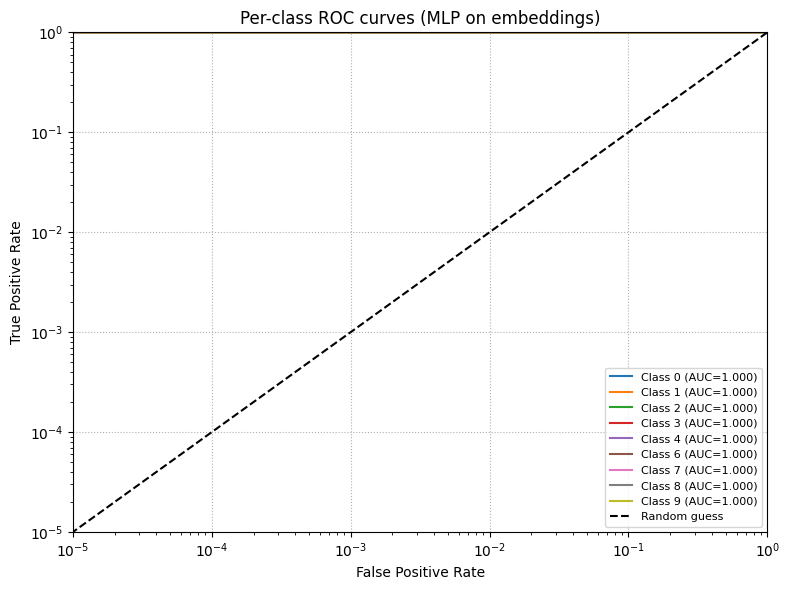

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for i in range(10):
    if np.sum(y_test == i) == 0:
        continue
    y_true_bin = (y_test == i).astype(int)
    y_score = probs_test[:, i]
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Per-class ROC curves (MLP on embeddings)")
# plt.xlim(0, 1)
plt.xlim(1e-5, 1)
plt.ylim(1e-5, 1.0)
# plt.ylim(0,1)
# plt.xscale("linear")
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()
